In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP


from scroutines import basicu
from scroutines import powerplots
from scroutines.miscu import is_in_polygon

import utils_merfish
from merfish_datasets import merfish_datasets
from merfish_genesets import get_all_genesets

import importlib
importlib.reload(powerplots)
importlib.reload(utils_merfish)

<module 'utils_merfish' from '/u/project/zipursky/f7xiesnm/v1-bb/v1/myvisctx/analysis_merfish/utils_merfish.py'>

In [2]:
np.random.seed(0)

In [3]:
def binning_pipe(adata, n=20, layer='ljnorm', bin_type='depth_bin'):
    """
    """
    assert bin_type in ['depth_bin', 'width_bin']
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_['width_bin'] = width_binned
    
    norm_mean = norm_.groupby(bin_type).mean(numeric_only=True)
    norm_sem  = norm_.groupby(bin_type).sem(numeric_only=True)
    norm_std  = norm_.groupby(bin_type).std(numeric_only=True)
    norm_n    = norm_[bin_type].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins

def binning_pipe2(adata, col_to_bin, bins=None, n=20, layer='ljnorm',):
    """
    """
    if bins is None:
        # bin it 
        bins, binned = utils_merfish.binning(adata.obs[col_to_bin].values, n)
    else:
        binned = pd.cut(adata.obs[col_to_bin].values, bins=bins)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['thebin'] = binned
    
    norm_mean = norm_.groupby('thebin').mean(numeric_only=True)
    norm_sem  = norm_.groupby('thebin').sem(numeric_only=True)
    norm_std  = norm_.groupby('thebin').std(numeric_only=True)
    norm_n    = norm_['thebin'].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, binned, bins 

# vision dependent genes (snRNA-seq)

In [4]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/DR_DEGs_240521.csv'
df_drdeg = pd.read_csv(f)

drdeg = df_drdeg['gene'].values
drupg = df_drdeg[df_drdeg['overall']=='DR_up']['gene'].values
drdng = df_drdeg[df_drdeg['overall']=='DR_dn']['gene'].values
df_drdeg.shape, drdeg.shape, drupg.shape, drdng.shape


((525, 4), (525,), (285,), (240,))

# A vs C at each age

In [5]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/Saumya_P6-21_AC_genes.csv'
df = pd.read_csv(f)
df.head()

,P6,P8,P10,P12,P14,P17,P21,P28,P38
0,Hs6st2,Shisa9,5730522E02Rik,Ptprk,Iqgap2,Igsf11,Ccdc85a,6530403H02Rik,Iqgap2
1,Galntl6,Xylt1,Dscaml1,Gabrg3,Nfib,Necab1,Rhbdl3,Nfib,6530403H02Rik
2,Magi1,6530403H02Rik,Grm1,6530403H02Rik,March1,Nfib,Pex5l,Nwd2,Cntn5
3,Gabrg3,Itpr1,Vwc2l,Xylt1,Ccdc85a,Met,Ryr3,Syt17,Ptprg
4,Hdac9,Nlgn1,Mgat4c,Asic2,Dpyd,March1,Itga8,Igsf11,March1


In [6]:
df_a = df.iloc[:25]
df_c = df.iloc[25:]

alltime_a = np.unique(df_a.values)
alltime_c = np.unique(df_c.values)

ac_overlap = np.intersect1d(alltime_a, alltime_c)

df_a.shape, df_c.shape, alltime_a.shape, alltime_c.shape, ac_overlap.shape

((25, 9), (25, 9), (75,), (85,), (0,))

In [7]:
alltime_a, alltime_c

(array(['5730522E02Rik', '6530403H02Rik', 'Adamts2', 'Arhgef28', 'Asic2',
        'Atp2b4', 'Camk2d', 'Ccdc85a', 'Ccser1', 'Cdh13', 'Cdh4', 'Celf4',
        'Cntn5', 'Cntnap5a', 'Dgkb', 'Dpyd', 'Dscaml1', 'Epha3', 'Epha6',
        'Fam155a', 'Fnbp1l', 'Gabrg3', 'Galntl6', 'Gm26871', 'Gpc5',
        'Gpc6', 'Grm1', 'Hdac9', 'Hs6st2', 'Igsf11', 'Iqgap2', 'Itga8',
        'Itpr1', 'Khdrbs2', 'Khdrbs3', 'Kirrel3', 'Lsamp', 'Magi1',
        'March1', 'Meis2', 'Met', 'Mgat4c', 'Necab1', 'Nedd4l', 'Nfib',
        'Nkain2', 'Nkain3', 'Nlgn1', 'Ntrk3', 'Nwd2', 'Opcml', 'Oxr1',
        'Pam', 'Pdzrn4', 'Pex5l', 'Plcxd3', 'Prkg1', 'Ptprg', 'Ptprk',
        'Raver2', 'Rfx3', 'Rhbdl3', 'Ryr3', 'Shisa9', 'Slit3', 'Smyd3',
        'Syt10', 'Syt17', 'Tenm1', 'Tenm4', 'Thsd7a', 'Tmeff2', 'Unc5c',
        'Vwc2l', 'Xylt1'], dtype=object),
 array(['Alcam', 'Astn2', 'B3galt1', 'Brinp1', 'Brinp3', 'Cacna2d3',
        'Cadps2', 'Camta1', 'Car10', 'Cdh12', 'Cdh20', 'Cdh6', 'Cdh7',
        'Cdh8', 'Chrm2', 'C

In [8]:
print(np.intersect1d(alltime_a, drdeg).shape)
print(np.intersect1d(alltime_c, drdeg).shape)

(5,)
(5,)


In [9]:
alltime_aup = np.intersect1d(alltime_a, drupg)
alltime_adn = np.intersect1d(alltime_a, drdng)
alltime_aup, alltime_adn

(array(['Cdh13', 'Gabrg3', 'Iqgap2', 'Syt17', 'Vwc2l'], dtype=object),
 array([], dtype=object))

In [10]:
alltime_cup = np.intersect1d(alltime_c, drupg)
alltime_cdn = np.intersect1d(alltime_c, drdng)
alltime_cup, alltime_cdn

(array(['Frmd6', 'Npnt'], dtype=object),
 array(['Astn2', 'Etl4', 'Slc24a3'], dtype=object))

# MERFISH

In [11]:
directories = merfish_datasets
print(merfish_datasets)

ddir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized" 
fout = os.path.join(ddir, 'P28NRDR_v1nonv1_merged_240520.h5ad')
!ls $ddir/*240411.h5ad 

{'P14NRa_ant': 'merfish_06142023/ant/region0', 'P28NRa_ant': 'merfish_06142023/ant/region1', 'P14NRa_pos': 'merfish_06142023/pos/region0', 'P28NRa_pos': 'merfish_06142023/pos/region1', 'P21NRa_ant': 'merfish_20231114/region0', 'P21DRa_ant': 'merfish_20231114/region2', 'P28DRa_ant': 'merfish_20231114/region1', 'P21NRa_pos': 'merfish_20231120/region0', 'P21DRa_pos': 'merfish_20231120/region1', 'P28DRa_pos': 'merfish_20231120/region2', 'P14NRb_ant': 'merfish_202404051211/region_0', 'P28NRb_ant': 'merfish_202404051211/region_1', 'P14NRb_pos': 'merfish_202404051214/region_0', 'P28NRb_pos': 'merfish_202404051214/region_1', 'P21NRb_ant': 'merfish_202404091526/region_2', 'P21DRb_ant': 'merfish_202404091526/region_1', 'P28DRb_ant': 'merfish_202404091526/region_0', 'P21NRb_pos': 'merfish_202404091601/region_0', 'P21DRb_pos': 'merfish_202404091601/region_2', 'P28DRb_pos': 'merfish_202404091601/region_1', 'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P1

In [12]:
%%time
fin = os.path.join(ddir, 'P28NRDR_v1l23_merged_240508.h5ad')
adata = ad.read(fin) 

clst_annots = adata.uns['clst_annots']
pcs = adata.obsm['pca']
ucs = adata.obsm['umap']
r = 0.3

names = [
    'P28NR_ant', 
    'P28NR_pos',
    'P28NRb_ant', 
    'P28NRb_pos',
    
    'P28DR_ant', 
    'P28DR_pos',
    'P28DRb_ant', 
    'P28DRb_pos',
]
adata

CPU times: user 67.7 ms, sys: 190 ms, total: 258 ms
Wall time: 1.76 s


AnnData object with n_obs × n_vars = 13276 × 500
    obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'depth', 'width', 'inside_v1l23', 'sample', 'norm_transcript_count', 'jnorm_transcript_count', 'depth_show', 'width_show', 'leiden_r0.3'
    uns: 'clst_annots', 'leiden', 'neighbors'
    obsm: 'blanks', 'pca', 'umap'
    layers: 'jnorm', 'ljnorm', 'norm'
    obsp: 'connectivities', 'distances'

In [13]:
genesets = get_all_genesets()
agenes = genesets['a']
bgenes = genesets['b']
cgenes = genesets['c']
iegs   = genesets['i']
up_agenes = genesets['a_up']
abcgenes = np.hstack([agenes, bgenes, cgenes])
merfish_genes = adata.var.index.values


agenes_idx = basicu.get_index_from_array(merfish_genes, agenes)
bgenes_idx = basicu.get_index_from_array(merfish_genes, bgenes)
cgenes_idx = basicu.get_index_from_array(merfish_genes, cgenes)
igenes_idx = basicu.get_index_from_array(merfish_genes, iegs)
len(merfish_genes), len(abcgenes)

(500, 170)

# MERFISH and AC genes overlap

In [14]:
print(np.intersect1d(alltime_a, merfish_genes).shape)
print(np.intersect1d(alltime_a, agenes).shape)
print(np.intersect1d(alltime_a, bgenes).shape)
print(np.intersect1d(alltime_a, cgenes).shape)
# print(np.intersect1d(alltime_a, iegs).shape)

print(np.intersect1d(alltime_a, merfish_genes))
print(np.intersect1d(alltime_a, agenes))
print(np.intersect1d(alltime_a, bgenes))
print(np.intersect1d(alltime_a, cgenes))

(40,)
(29,)
(2,)
(0,)
['6530403H02Rik' 'Adamts2' 'Arhgef28' 'Camk2d' 'Cdh13' 'Cdh4' 'Cntn5'
 'Cntnap5a' 'Dgkb' 'Dpyd' 'Dscaml1' 'Epha3' 'Epha6' 'Gabrg3' 'Galntl6'
 'Gpc5' 'Grm1' 'Igsf11' 'Iqgap2' 'Itga8' 'Kirrel3' 'Magi1' 'Meis2' 'Met'
 'Necab1' 'Nfib' 'Nkain3' 'Ntrk3' 'Pdzrn4' 'Ptprg' 'Ptprk' 'Rfx3' 'Rhbdl3'
 'Ryr3' 'Shisa9' 'Syt10' 'Syt17' 'Tenm1' 'Unc5c' 'Vwc2l']
['6530403H02Rik' 'Adamts2' 'Arhgef28' 'Camk2d' 'Cdh13' 'Cntn5' 'Dpyd'
 'Dscaml1' 'Epha6' 'Gabrg3' 'Gpc5' 'Grm1' 'Igsf11' 'Iqgap2' 'Itga8'
 'Kirrel3' 'Meis2' 'Met' 'Necab1' 'Nfib' 'Nkain3' 'Pdzrn4' 'Rfx3' 'Rhbdl3'
 'Ryr3' 'Syt10' 'Syt17' 'Tenm1' 'Vwc2l']
['Cdh4' 'Epha3']
[]


In [15]:
print(np.intersect1d(alltime_c, merfish_genes).shape)
print(np.intersect1d(alltime_c, agenes).shape)
print(np.intersect1d(alltime_c, bgenes).shape)
print(np.intersect1d(alltime_c, cgenes).shape)
# print(np.intersect1d(alltime_c, iegs).shape)

print(np.intersect1d(alltime_c, merfish_genes))
print(np.intersect1d(alltime_c, agenes))
print(np.intersect1d(alltime_c, bgenes))
print(np.intersect1d(alltime_c, cgenes))

(44,)
(1,)
(0,)
(27,)
['Alcam' 'Astn2' 'Brinp3' 'Cacna2d3' 'Cadps2' 'Car10' 'Cdh12' 'Cdh20'
 'Cdh6' 'Cdh8' 'Chrm2' 'Chrm3' 'Cntn4' 'Cntnap2' 'Cpne4' 'Cux1' 'Egfem1'
 'Etl4' 'Foxp1' 'Gm13629' 'Grid2' 'Grm3' 'Hs3st4' 'Hs6st3' 'Igfbp5'
 'Kcnh5' 'Kcnq5' 'Lrp1b' 'Ncam2' 'Osbpl3' 'Ptchd4' 'Ptprt' 'Ralyl' 'Rcan2'
 'Rora' 'Rorb' 'Satb1' 'Scn1a' 'Scube1' 'Sema6d' 'Slc24a3' 'Tox' 'Trpm3'
 'Zmat4']
['Egfem1']
[]
['Alcam' 'Astn2' 'Brinp3' 'Cadps2' 'Cdh12' 'Cdh20' 'Chrm2' 'Cntnap2'
 'Cpne4' 'Etl4' 'Foxp1' 'Gm13629' 'Grid2' 'Hs3st4' 'Kcnh5' 'Kcnq5' 'Ncam2'
 'Osbpl3' 'Ptchd4' 'Rcan2' 'Rorb' 'Scn1a' 'Scube1' 'Sema6d' 'Slc24a3'
 'Tox' 'Zmat4']


In [16]:
alltime_am = np.intersect1d(alltime_a, merfish_genes)
alltime_cm = np.intersect1d(alltime_c, merfish_genes)
alltime_am, alltime_cm

(array(['6530403H02Rik', 'Adamts2', 'Arhgef28', 'Camk2d', 'Cdh13', 'Cdh4',
        'Cntn5', 'Cntnap5a', 'Dgkb', 'Dpyd', 'Dscaml1', 'Epha3', 'Epha6',
        'Gabrg3', 'Galntl6', 'Gpc5', 'Grm1', 'Igsf11', 'Iqgap2', 'Itga8',
        'Kirrel3', 'Magi1', 'Meis2', 'Met', 'Necab1', 'Nfib', 'Nkain3',
        'Ntrk3', 'Pdzrn4', 'Ptprg', 'Ptprk', 'Rfx3', 'Rhbdl3', 'Ryr3',
        'Shisa9', 'Syt10', 'Syt17', 'Tenm1', 'Unc5c', 'Vwc2l'],
       dtype=object),
 array(['Alcam', 'Astn2', 'Brinp3', 'Cacna2d3', 'Cadps2', 'Car10', 'Cdh12',
        'Cdh20', 'Cdh6', 'Cdh8', 'Chrm2', 'Chrm3', 'Cntn4', 'Cntnap2',
        'Cpne4', 'Cux1', 'Egfem1', 'Etl4', 'Foxp1', 'Gm13629', 'Grid2',
        'Grm3', 'Hs3st4', 'Hs6st3', 'Igfbp5', 'Kcnh5', 'Kcnq5', 'Lrp1b',
        'Ncam2', 'Osbpl3', 'Ptchd4', 'Ptprt', 'Ralyl', 'Rcan2', 'Rora',
        'Rorb', 'Satb1', 'Scn1a', 'Scube1', 'Sema6d', 'Slc24a3', 'Tox',
        'Trpm3', 'Zmat4'], dtype=object))

# MERFISH analysis

In [17]:
from scipy import stats

In [18]:
from matplotlib.colors import LinearSegmentedColormap

colors_a = [(0.0, 'black'), (1.0, 'C0')]      
colors_b = [(0.0, 'black'), (1.0, 'C1')]      
colors_c = [(0.0, 'black'), (1.0, 'C2')]      
colors_nrdr = [(0.0, 'C1'), (0.5, 'white'), (1.0, 'black')]
colors_nr = [(0.0, 'white'), (1.0, 'C1'),]
colors_dr = [(0.0, 'white'), (1.0, 'black'),]

# Create a custom colormap using LinearSegmentedColormap
cmap_a = LinearSegmentedColormap.from_list('cmap_a', colors_a)
cmap_b = LinearSegmentedColormap.from_list('cmap_b', colors_b)
cmap_c = LinearSegmentedColormap.from_list('cmap_c', colors_c)
cmap_nrdr = LinearSegmentedColormap.from_list('cmap_nrdr', colors_nrdr)
cmap_nr = LinearSegmentedColormap.from_list('cmap_nr', colors_nr)
cmap_dr = LinearSegmentedColormap.from_list('cmap_dr', colors_dr)

In [19]:
adata.obs['annot'] = clst_annots[adata.obs[f'leiden_r{r}'].astype(int)]
print(adata.obs['annot'].value_counts())

Glu0    3107
Glu1    2802
Glu2    2424
3       1227
4       1017
5        936
6        931
7        452
8        380
Name: annot, dtype: int64


In [20]:
adata = adata[adata.obs['annot'].str.contains('Glu')]
print(adata)
# # adata = adata[adata.obs['gncov']>100]
# print(adata)

View of AnnData object with n_obs × n_vars = 8333 × 500
    obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'depth', 'width', 'inside_v1l23', 'sample', 'norm_transcript_count', 'jnorm_transcript_count', 'depth_show', 'width_show', 'leiden_r0.3', 'annot'
    uns: 'clst_annots', 'leiden', 'neighbors'
    obsm: 'blanks', 'pca', 'umap'
    layers: 'jnorm', 'ljnorm', 'norm'
    obsp: 'connectivities', 'distances'


In [21]:
width_min = adata.obs.groupby('sample')['width'].min().reindex(names)
width_max = adata.obs.groupby('sample')['width'].max().reindex(names)
width_rng = width_max - width_min 
width_cum = pd.Series(np.cumsum(np.hstack([0, width_rng[:-1]+100])), index=names)

adata.obs['width_n0'] = adata.obs['width'] - width_min.reindex(adata.obs['sample']).values
adata.obs['width_show2'] =  adata.obs['width_n0'] + width_cum.reindex(adata.obs['sample']).values
adata.obs['depth_show2'] = -adata.obs['depth']

/tmp/ipykernel_4950/3850898509.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['width_n0'] = adata.obs['width'] - width_min.reindex(adata.obs['sample']).values


In [22]:
mat = adata[:,abcgenes].layers['ljnorm']
mat = stats.zscore(mat, axis=0)

mat_nr = adata[adata.obs['sample'].str.contains('NR'), abcgenes].layers['ljnorm']
mat_nr = stats.zscore(mat_nr, axis=0)

pca = PCA(n_components=5)
pcs_typegenes = pca.fit(mat).transform(mat)
# pcs_typegenes = pca.fit(mat_nr).transform(mat)
adata.obsm['pcs_typegenes'] = pcs_typegenes

In [23]:
xi, yi = 1, 2
xsign, ysign = -1,-1

In [24]:
# get ABC scores
g0_a = adata[:,agenes].layers['ljnorm'].mean(axis=1)
g0_b = adata[:,bgenes].layers['ljnorm'].mean(axis=1)
g0_c = adata[:,cgenes].layers['ljnorm'].mean(axis=1)

# make ABC scores comparable and norm to [0,1] [50% to 95%]
vmin_p, vmax_p = 30, 95
vmin_a = np.percentile(g0_a, vmin_p)
vmax_a = np.percentile(g0_a, vmax_p)

vmin_b = np.percentile(g0_b, vmin_p)
vmax_b = np.percentile(g0_b, vmax_p)

vmin_c = np.percentile(g0_c, vmin_p)
vmax_c = np.percentile(g0_c, vmax_p)

g0_a = np.clip((g0_a-vmin_a)/(vmax_a-vmin_a), 0, 1)
g0_b = np.clip((g0_b-vmin_b)/(vmax_b-vmin_b), 0, 1)
g0_c = np.clip((g0_c-vmin_c)/(vmax_c-vmin_c), 0, 1)

# separate them into scale and frequency
g0_sum  = (g0_a+g0_b+g0_c)
g0_size = np.clip(g0_sum/np.percentile(g0_sum, 50), 0, 1) # [0 - > 50%] - [0, 1]
freq0_a = g0_a/(g0_sum+1e-5)
freq0_b = g0_b/(g0_sum+1e-5)
freq0_c = g0_c/(g0_sum+1e-5)

adata.obs['raw_score_a'] = adata[:,agenes].layers['ljnorm'].mean(axis=1)
adata.obs['raw_score_b'] = adata[:,bgenes].layers['ljnorm'].mean(axis=1)
adata.obs['raw_score_c'] = adata[:,cgenes].layers['ljnorm'].mean(axis=1)

adata.obsm['size_freq_abc'] = np.vstack([g0_size, freq0_a, freq0_b, freq0_c, g0_sum]).T

In [25]:
%%time

from py_pcha import PCHA

np.random.seed(0)

X = np.vstack([
    xsign*adata.obsm['pcs_typegenes'][:,xi], 
    ysign*adata.obsm['pcs_typegenes'][:,yi], 
])

# X = np.vstack([
#     xsign*adata[adata.obs['sample'].str.contains('NR')].obsm['pcs_typegenes'][:,xi], 
#     ysign*adata[adata.obs['sample'].str.contains('NR')].obsm['pcs_typegenes'][:,yi], 
# ])


XC, S, C, SSE, varexpl = PCHA(X, noc=3, delta=0)
XC = np.array(XC)
XC = XC[:,np.argsort(XC[0])].copy() # order this
print(XC.shape, S.shape, C.shape, SSE.shape, varexpl.shape, SSE, varexpl)




(2, 3) (3, 8333) (8333, 3) () () 264.0139312123938 0.9965380443454968
CPU times: user 6.97 s, sys: 21.5 ms, total: 7 s
Wall time: 7.04 s


In [26]:
def add_triangle(XC, ax, zorder=0, vertices=False, **kwargs):
    # add the triangle
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--',  color='gray', label='', zorder=zorder, linewidth=1, markersize=3)
    
    # add vertices
    if vertices:
        ax.scatter(XC[0,0], XC[1,0], color='C0', zorder=zorder, **kwargs)
        ax.scatter(XC[0,1], XC[1,1], color='C1', zorder=zorder, **kwargs)
        ax.scatter(XC[0,2], XC[1,2], color='C2', zorder=zorder, **kwargs)

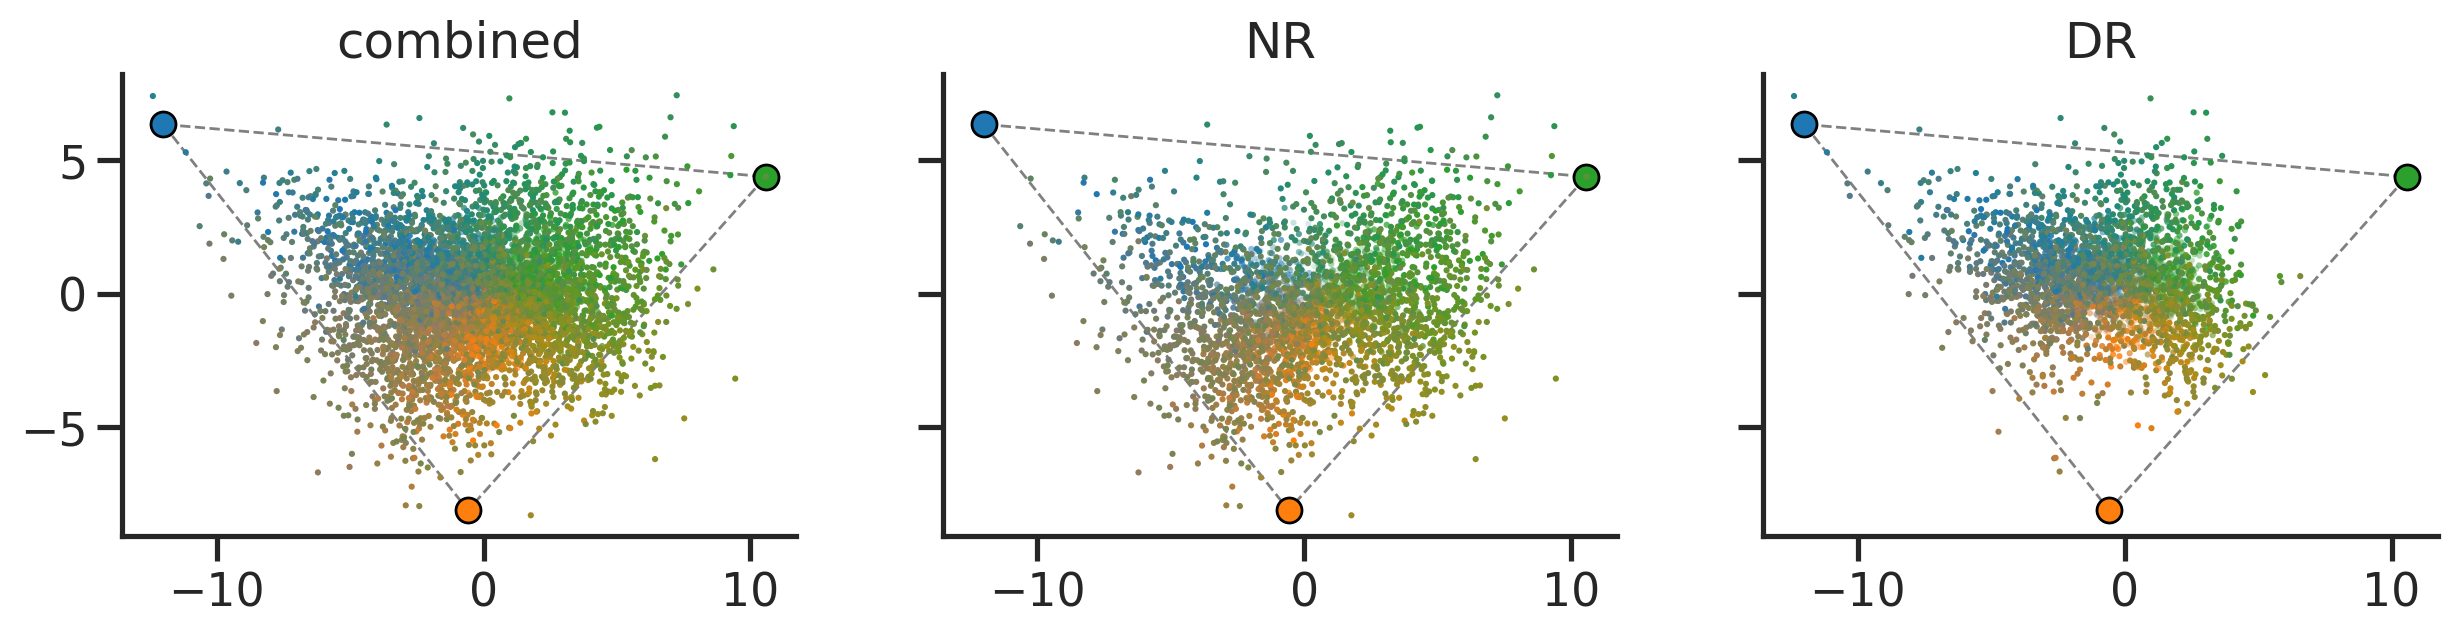

In [27]:
adatas = [
    adata,
    adata[adata.obs['sample'].str.contains('NR')],
    adata[adata.obs['sample'].str.contains('DR')],
]
conditions = ['combined', 'NR', 'DR']

fig, axs = plt.subplots(1,3,figsize=(3*5,1*3), sharex=True, sharey=True)
for i, (ax, adatasub, condition) in enumerate(zip(axs, adatas, conditions)):
    condition = conditions[i]
    x = xsign*adatasub.obsm['pcs_typegenes'][:,xi]
    y = ysign*adatasub.obsm['pcs_typegenes'][:,yi]
    
    g_size = adatasub.obsm['size_freq_abc'][:,0]
    freq_a = adatasub.obsm['size_freq_abc'][:,1]
    freq_b = adatasub.obsm['size_freq_abc'][:,2]
    freq_c = adatasub.obsm['size_freq_abc'][:,3]
    
    # visualize ABC scores using additive blending
    additive = (cmap_a(freq_a)+cmap_b(freq_b)+cmap_c(freq_c))[:,:3]
    p = ax.scatter(x, y, c=additive, s=5, edgecolor='none', alpha=g_size)
        
    # Show ticks but no grid
    ax.set_aspect('equal')
    ax.axis('on')
    ax.grid(False)  # Turn off grid lines
    sns.despine(ax=ax)
    ax.tick_params(axis='both', which='both', bottom=True, left=True)
    ax.set_title(condition)

    # add the triangle
    add_triangle(XC, ax, vertices=True, edgecolors='k', linewidths=1, marker='o')
plt.show()

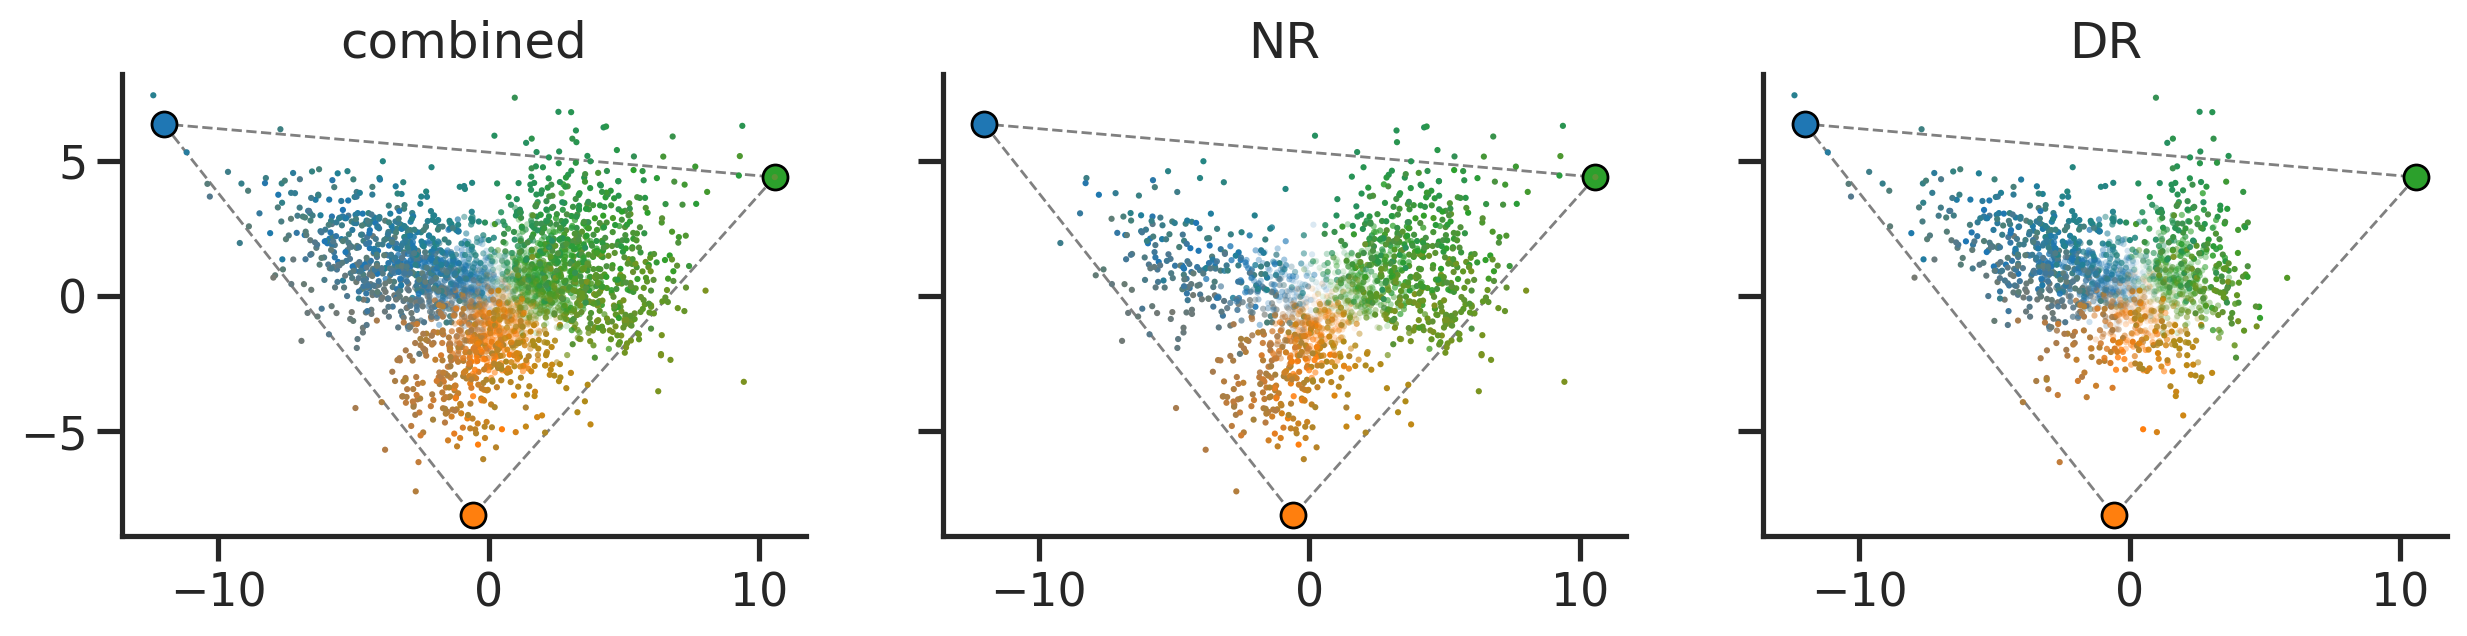

In [28]:

adatas = [
    adata,
    adata[adata.obs['sample'].str.contains('NR')],
    adata[adata.obs['sample'].str.contains('DR')],
]
conditions = ['combined', 'NR', 'DR']

fig, axs = plt.subplots(1,3,figsize=(3*5,1*3), sharex=True, sharey=True)
for i, (ax, adatasub, condition) in enumerate(zip(axs, adatas, conditions)):
    condition = conditions[i]
    x = xsign*adatasub.obsm['pcs_typegenes'][:,xi]
    y = ysign*adatasub.obsm['pcs_typegenes'][:,yi]
    
    g_size = adatasub.obsm['size_freq_abc'][:,0]
    freq_a = adatasub.obsm['size_freq_abc'][:,1]
    freq_b = adatasub.obsm['size_freq_abc'][:,2]
    freq_c = adatasub.obsm['size_freq_abc'][:,3]
    
    # visualize ABC scores using additive blending
    additive = (cmap_a(freq_a)+cmap_b(freq_b)+cmap_c(freq_c))[:,:3]
    
    
    th = 0.6
    cond = np.sum(np.array([freq_a > th, freq_b > th, freq_c > th]), axis=0) > 0
    
    p = ax.scatter(x[cond], y[cond], c=additive[cond], s=5, edgecolor='none', alpha=g_size[cond])
        
    # Show ticks but no grid
    ax.set_aspect('equal')
    ax.axis('on')
    ax.grid(False)  # Turn off grid lines
    sns.despine(ax=ax)
    ax.tick_params(axis='both', which='both', bottom=True, left=True)
    ax.set_title(condition)

    # add the triangle
    add_triangle(XC, ax, vertices=True, edgecolors='k', linewidths=1, marker='o')
plt.show()

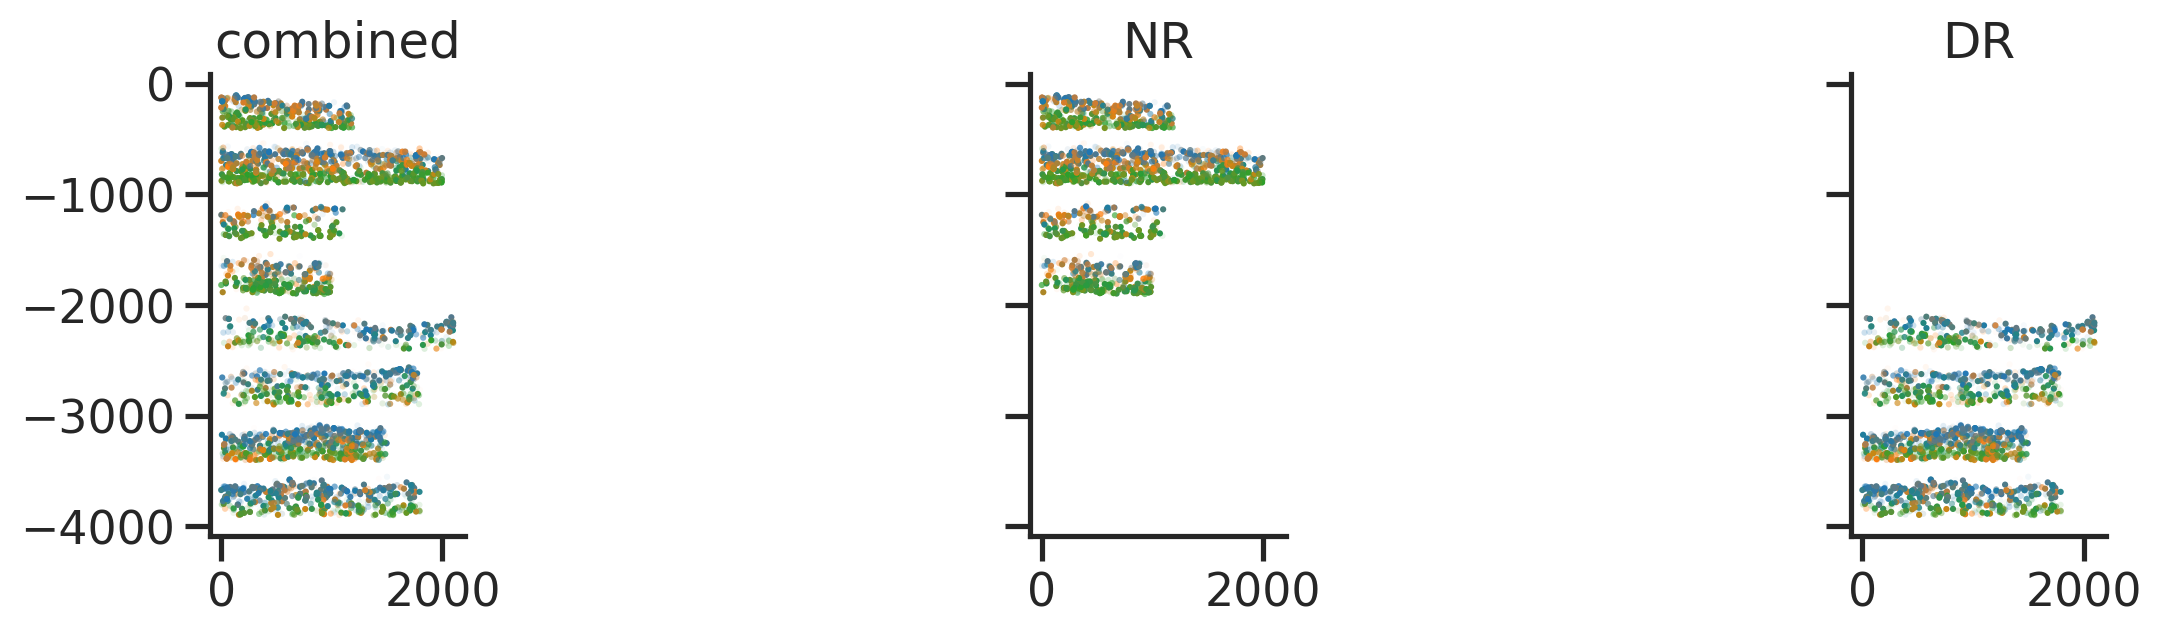

In [29]:

adatas = [
    adata,
    adata[adata.obs['sample'].str.contains('NR')],
    adata[adata.obs['sample'].str.contains('DR')],
]
conditions = ['combined', 'NR', 'DR']

fig, axs = plt.subplots(1,3,figsize=(3*5,1*3), sharex=True, sharey=True)
for i, (ax, adatasub, condition) in enumerate(zip(axs, adatas, conditions)):
    condition = conditions[i]
    x = adatasub.obs['width_show']
    y = adatasub.obs['depth_show']
    
    g_size = adatasub.obsm['size_freq_abc'][:,0]
    freq_a = adatasub.obsm['size_freq_abc'][:,1]
    freq_b = adatasub.obsm['size_freq_abc'][:,2]
    freq_c = adatasub.obsm['size_freq_abc'][:,3]
    
    # visualize ABC scores using additive blending
    additive = (cmap_a(freq_a)+cmap_b(freq_b)+cmap_c(freq_c))[:,:3]
    
    
    th = 0.6
    cond = np.sum(np.array([freq_a > th, freq_b > th, freq_c > th]), axis=0) > 0
    
    p = ax.scatter(x[cond], y[cond], c=additive[cond], s=5, edgecolor='none', alpha=g_size[cond])
        
    # Show ticks but no grid
    ax.set_aspect('equal')
    ax.axis('on')
    ax.grid(False)  # Turn off grid lines
    sns.despine(ax=ax)
    ax.tick_params(axis='both', which='both', bottom=True, left=True)
    ax.set_title(condition)

plt.show()

In [30]:
# cellinfo = adata.obs.copy()
adata.obs['ABC_06'] = 'N' 
adata.obs.loc[adata.obsm['size_freq_abc'][:,1] > 0.6, 'ABC_06'] = 'A' 
adata.obs.loc[adata.obsm['size_freq_abc'][:,2] > 0.6, 'ABC_06'] = 'B' 
adata.obs.loc[adata.obsm['size_freq_abc'][:,3] > 0.6, 'ABC_06'] = 'C' 
adata.obs

,EntityID,fov,volume,center_x,center_y,min_x,min_y,max_x,max_y,anisotropy,...,width_show,leiden_r0.3,annot,width_n0,width_show2,depth_show2,raw_score_a,raw_score_b,raw_score_c,ABC_06
229024_P28NR_ant,2595481502794100052,2377,225.558407,12809.935921,6511.924201,12804.820512,6506.498029,12814.463080,6517.014457,1.075331,...,1194.554534,2,Glu2,1194.554534,1194.554534,-352.396222,0.107333,0.267104,0.290381,N
229039_P28NR_ant,2595481502794100081,2377,491.735065,12789.191520,6532.710385,12783.007860,6528.813358,12794.724146,6536.320135,1.569733,...,1165.500070,0,Glu0,1165.500070,1165.500070,-356.666322,0.237989,0.578569,0.375901,N
229047_P28NR_ant,2595481502794100094,2377,147.163184,12770.224040,6497.141232,12767.167078,6493.750550,12772.240175,6499.304514,1.896621,...,1182.758477,1,Glu1,1182.758477,1182.758477,-393.095395,0.000000,0.062064,0.428672,C
229055_P28NR_ant,2595481502794100112,2377,1238.295865,12791.291164,6520.161279,12783.588616,6514.964419,12800.796861,6531.344572,1.197166,...,1176.828441,0,Glu0,1176.828441,1176.828441,-362.459126,0.383538,0.438328,0.358888,N
229057_P28NR_ant,2595481502794100114,2377,263.837653,12753.580524,6524.236818,12747.875361,6515.648286,12758.848313,6531.393342,1.502138,...,1151.081489,1,Glu1,1151.081489,1151.081489,-390.312256,0.103755,0.489143,0.709223,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19366_P28DRb_pos,2027846600314100249,854,583.292831,5042.006911,602.754295,5030.817057,593.865386,5049.882301,612.194151,1.175064,...,177.360617,1,Glu1,177.360617,11556.169143,-385.889804,0.133652,0.204035,0.541929,C
19396_P28DRb_pos,2027846600315100028,854,828.995414,5196.914355,612.378470,5191.005606,605.976507,5202.388934,617.944943,1.099675,...,16.131301,1,Glu1,16.131301,11394.939827,-355.611689,0.157529,0.241756,0.405505,N
19406_P28DRb_pos,2027846600315100043,854,268.979777,5186.945125,641.318141,5182.905699,637.602446,5193.858981,646.782238,1.364364,...,18.062370,1,Glu1,18.062370,11396.870896,-386.159374,0.163085,0.560366,0.413487,N
19470_P28DRb_pos,2027846600315100159,854,133.858000,5182.951227,592.689065,5179.177757,589.005350,5187.269107,597.209413,1.423538,...,34.819286,2,Glu2,34.819286,11413.627812,-340.334228,0.089102,0.239885,0.053545,B


In [31]:
adata.obs.columns

Index(['EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y',
       'max_x', 'max_y', 'anisotropy', 'transcript_count',
       'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass',
       'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y',
       'depth', 'width', 'inside_v1l23', 'sample', 'norm_transcript_count',
       'jnorm_transcript_count', 'depth_show', 'width_show', 'leiden_r0.3',
       'annot', 'width_n0', 'width_show2', 'depth_show2', 'raw_score_a',
       'raw_score_b', 'raw_score_c', 'ABC_06'],
      dtype='object')

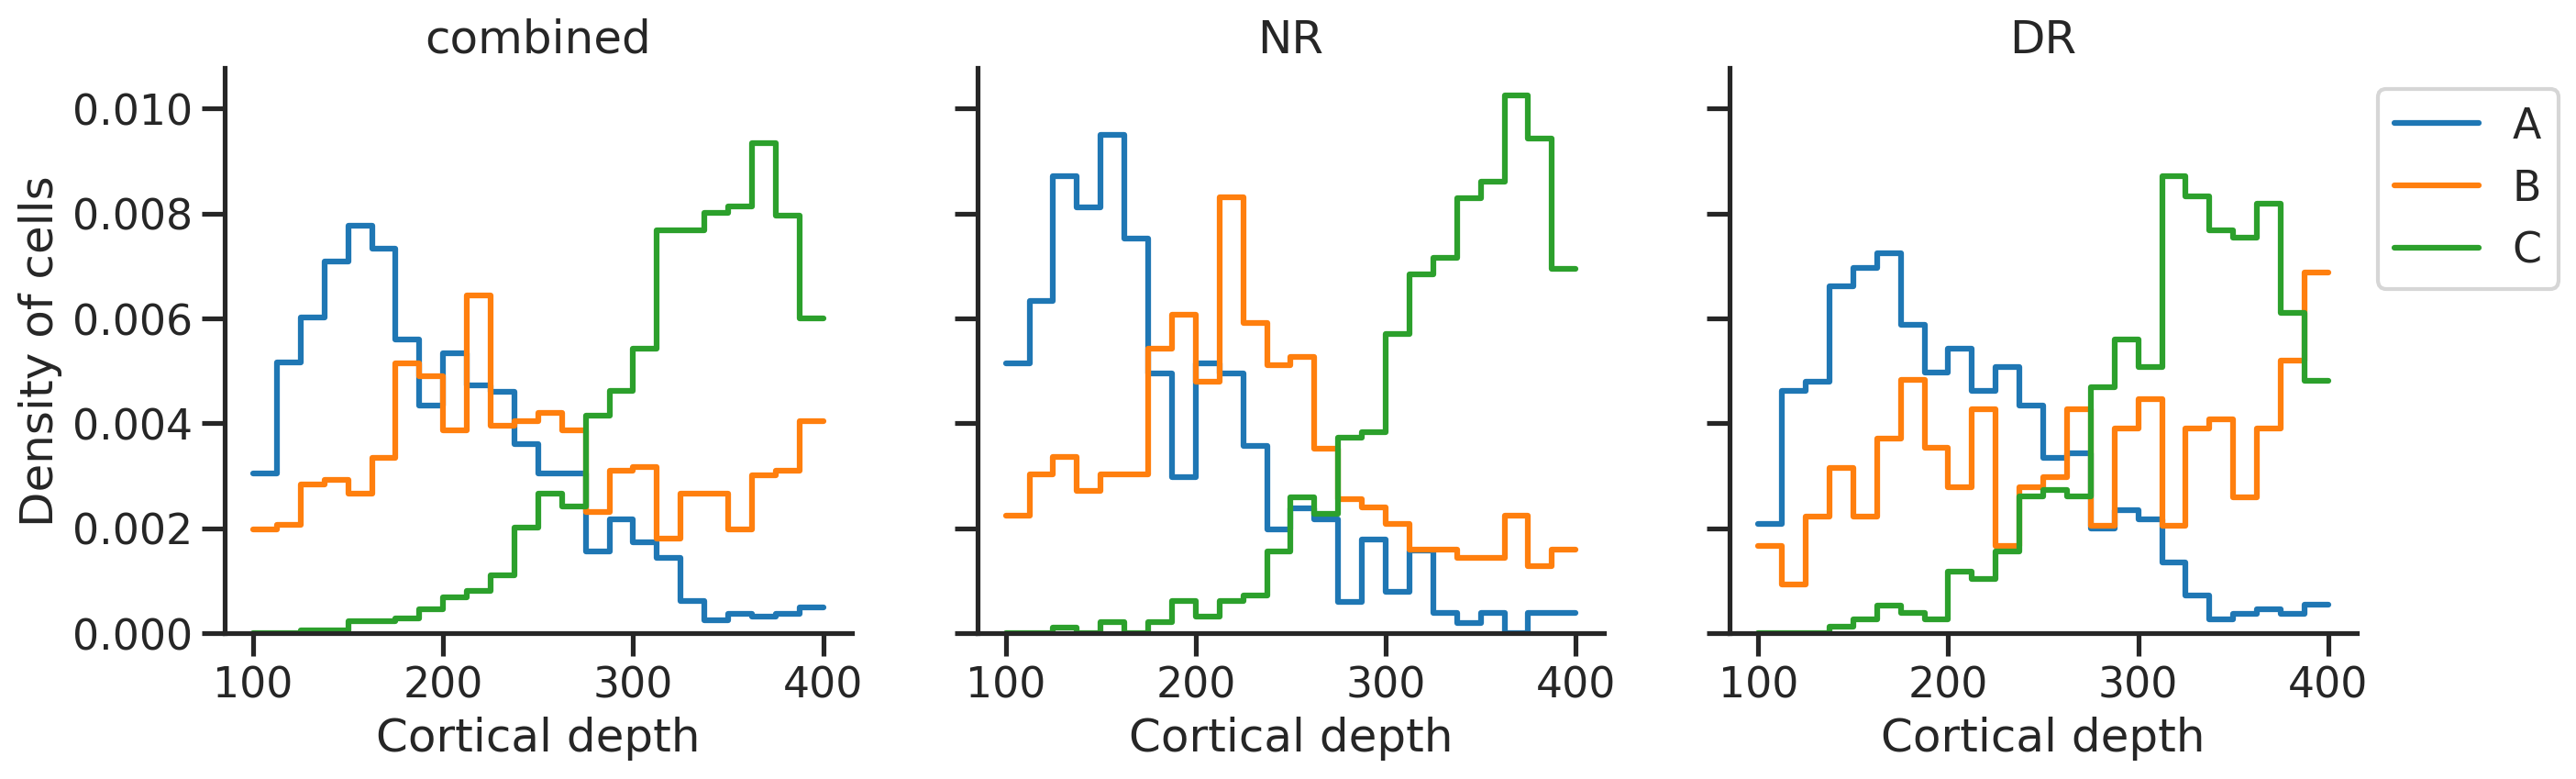

In [32]:
bins = np.linspace(100,400,25)
dfplot = adata.obs
dfplot_nr = adata.obs[adata.obs['sample'].str.contains('NR')]
dfplot_dr = adata.obs[adata.obs['sample'].str.contains('DR')]

stat = 'density'
# stat = 'count'
fig, axs = plt.subplots(1,3,figsize=(3*5,1*4), sharex=True, sharey=True)
for ax, dfplot, title in zip(axs, [dfplot, dfplot_nr, dfplot_dr], ['combined', 'NR', 'DR']):
    depths_a = dfplot[dfplot['ABC_06']=='A']['depth'].values
    depths_b = dfplot[dfplot['ABC_06']=='B']['depth'].values
    depths_c = dfplot[dfplot['ABC_06']=='C']['depth'].values
    # depths_n = dfplot[dfplot['ABC_06']=='N']['depth'].values
    sns.histplot(depths_a, bins=bins, element='step', stat=stat, color='C0', fill=False, label='A', ax=ax)
    sns.histplot(depths_b, bins=bins, element='step', stat=stat, color='C1', fill=False, label='B', ax=ax)
    sns.histplot(depths_c, bins=bins, element='step', stat=stat, color='C2', fill=False, label='C', ax=ax)
    # sns.histplot(depths_n, bins=bins, element='step', stat=stat, color='gray', fill=False, label='N', ax=ax)
    sns.despine(ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Cortical depth')
    ax.set_ylabel('Density of cells')
    ax.grid(False)
ax.legend(bbox_to_anchor=(1,1))

In [33]:
abcn_counts = adata.obs.groupby(['sample', 'ABC_06']).size().unstack()[['A', 'B', 'C']]
abcn_freq = abcn_counts.divide(abcn_counts.sum(axis=1), axis=0)
# abcn_freq
abcn_freq

ABC_06,A,B,C
sample,,,
P28DR_ant,0.480769,0.185897,0.333333
P28DR_pos,0.428894,0.225734,0.345372
P28DRb_ant,0.432181,0.267287,0.300532
P28DRb_pos,0.547414,0.168103,0.284483
P28NR_ant,0.244957,0.331412,0.423631
P28NR_pos,0.283737,0.306805,0.409458
P28NRb_ant,0.143713,0.353293,0.502994
P28NRb_pos,0.192878,0.249258,0.557864


In [34]:
adata_a = adata[adata.obs['ABC_06']=='A']
adata_a_nr = adata_a[adata_a.obs['sample'].str.contains('NR')]
adata_a_dr = adata_a[adata_a.obs['sample'].str.contains('DR')]

adata_b = adata[adata.obs['ABC_06']=='B']
adata_b_nr = adata_b[adata_b.obs['sample'].str.contains('NR')]
adata_b_dr = adata_b[adata_b.obs['sample'].str.contains('DR')]

adata_c = adata[adata.obs['ABC_06']=='C']
adata_c_nr = adata_c[adata_c.obs['sample'].str.contains('NR')]
adata_c_dr = adata_c[adata_c.obs['sample'].str.contains('DR')]

In [35]:
dfmean = pd.DataFrame(index=merfish_genes)
dfmean['A_nr'] = np.mean(adata_a_nr.layers['ljnorm'], axis=0)
dfmean['B_nr'] = np.mean(adata_b_nr.layers['ljnorm'], axis=0)
dfmean['C_nr'] = np.mean(adata_c_nr.layers['ljnorm'], axis=0)

dfmean['A_dr'] = np.mean(adata_a_dr.layers['ljnorm'], axis=0)
dfmean['B_dr'] = np.mean(adata_b_dr.layers['ljnorm'], axis=0)
dfmean['C_dr'] = np.mean(adata_c_dr.layers['ljnorm'], axis=0)

dfmean.shape

(500, 6)

<module 'matplotlib.pyplot' from '/u/home/f/f7xiesnm/.conda/envs/napari/lib/python3.9/site-packages/matplotlib/pyplot.py'>

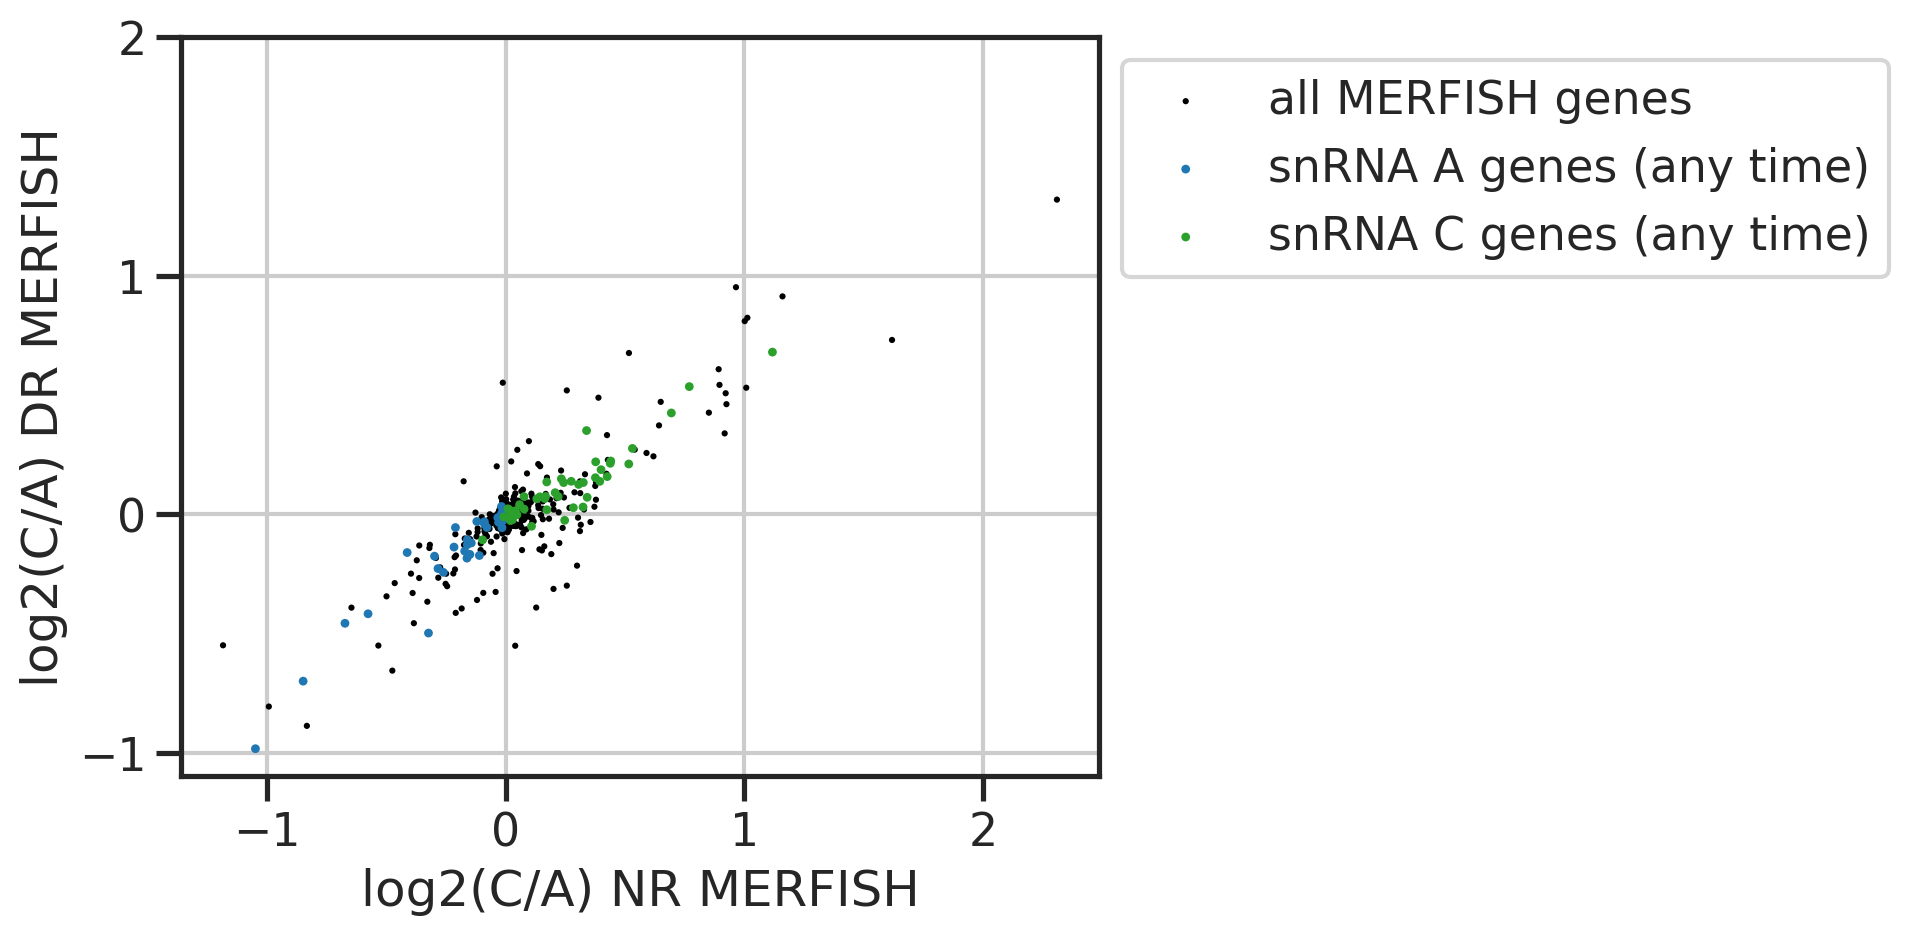

In [36]:
fig, ax = plt.subplots()
ax.scatter(dfmean['C_nr']-dfmean['A_nr'], 
           dfmean['C_dr']-dfmean['A_dr'], 
           s=5, edgecolor='none', color='k', label='all MERFISH genes'
           )
ax.scatter((dfmean['C_nr']-dfmean['A_nr']).loc[alltime_am], 
           (dfmean['C_dr']-dfmean['A_dr']).loc[alltime_am], 
           s=10, edgecolor='none', color='C0', label='snRNA A genes (any time)'
           )
ax.scatter((dfmean['C_nr']-dfmean['A_nr']).loc[alltime_cm], 
           (dfmean['C_dr']-dfmean['A_dr']).loc[alltime_cm], 
           s=10, edgecolor='none', color='C2', label='snRNA C genes (any time)'
           )
ax.set_aspect('equal')
ax.set_xticks([-1,0,1,2,])
ax.set_yticks([-1,0,1,2,])
ax.set_xlabel('log2(C/A) NR MERFISH')
ax.set_ylabel('log2(C/A) DR MERFISH')
ax.legend(bbox_to_anchor=(1,1))
plt

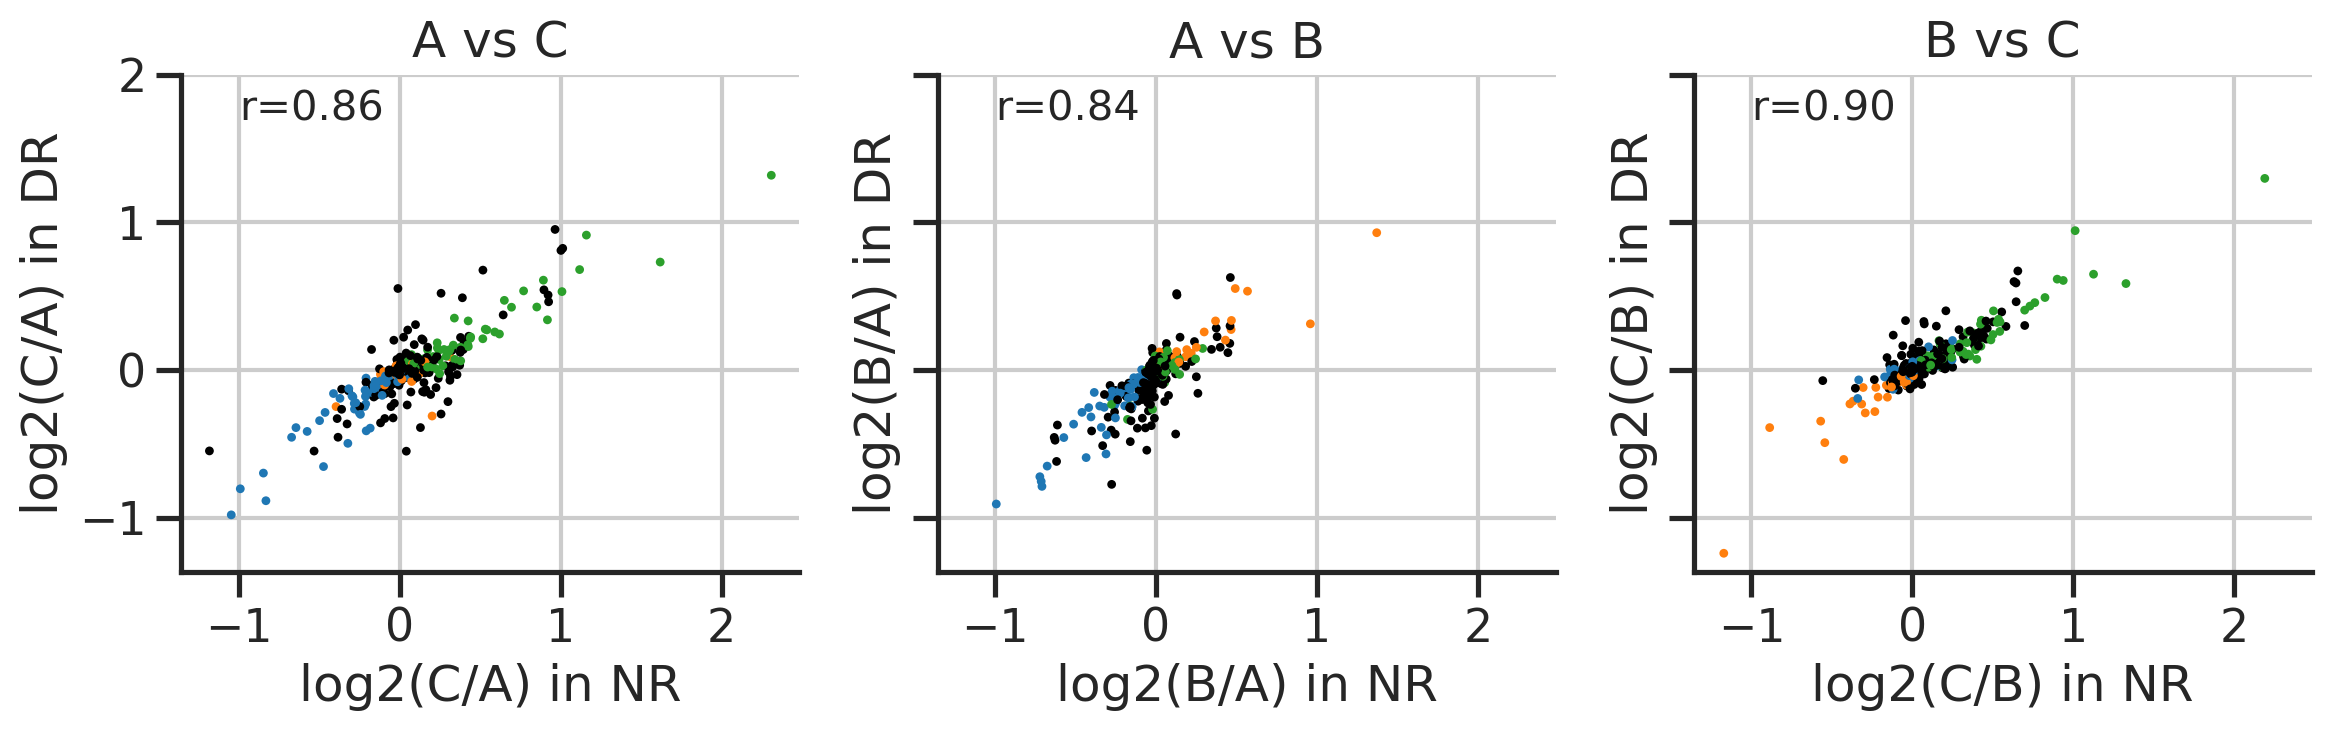

In [38]:
pairs = [
    ['C', 'A'],
    ['B', 'A'],
    ['C', 'B'],
]
fig, axs = plt.subplots(1,3,figsize=(3*4,1*4), sharex=True, sharey=True) # , sharey=False)
for i in range(3):
    ax = axs[i]
    pm, pn = pairs[i]
    
    _x = dfmean[f'{pm}_nr'] - dfmean[f'{pn}_nr'].values
    _y = dfmean[f'{pm}_dr'] - dfmean[f'{pn}_dr'].values
    _c = np.array(['k']*500).astype('<U2') 
    _c[agenes_idx] = 'C0'
    _c[bgenes_idx] = 'C1'
    _c[cgenes_idx] = 'C2'
    # _c[igenes_idx] = 'C3'
    sorting = np.argsort(np.abs(_x)+np.abs(_y))
    
    # r, p = stats.spearmanr(_x, _y)
    r, p = stats.pearsonr(_x, _y)
    ax.scatter(_x, _y, c=_c,#,['C0']*500,
               s=10, edgecolor='none', label='MERFISH genes'
               )
    ax.set_title(f'{pn} vs {pm}')
    ax.text(-1, 1.9, f'r={r:.2f}', va='top', fontsize=15)
    
    ax.set_xlabel(f'log2({pm}/{pn}) in NR')
    ax.set_ylabel(f'log2({pm}/{pn}) in DR')
    sns.despine(ax=ax)
    
    ax.set_xticks([-1,0,1,2])
    ax.set_yticks([-1,0,1,2])
    
fig.tight_layout()
# ax.legend(bbox_to_anchor=(1,1))

In [39]:
# sns.histplot((dfmean['C_nr']-dfmean['A_nr']).values, stat='density')
# sns.histplot((dfmean['C_nr']-dfmean['A_nr']).loc[alltime_am].values, stat='density')
# sns.histplot((dfmean['C_nr']-dfmean['A_nr']).loc[alltime_cm].values, stat='density')

In [40]:
merfish_a = merfish_genes[dfmean['C_nr']-dfmean['A_nr']<-0.2]
merfish_c = merfish_genes[dfmean['C_nr']-dfmean['A_nr']> 0.2]
merfish_a.shape, merfish_c.shape

((40,), (73,))

In [41]:
print(merfish_a.shape, merfish_c.shape, alltime_a.shape, alltime_c.shape)

print(np.intersect1d(merfish_a, alltime_am).shape)
print(np.intersect1d(merfish_c, alltime_cm).shape)

print(np.intersect1d(merfish_a, alltime_cm).shape)
print(np.intersect1d(merfish_c, alltime_am).shape)


alltime_amm = np.intersect1d(merfish_a, alltime_am)
alltime_cmm = np.intersect1d(merfish_c, alltime_cm)
alltime_amm, alltime_cmm

(40,) (73,) (75,) (85,)
(11,)
(24,)
(0,)
(0,)


(array(['Adamts2', 'Camk2d', 'Dscaml1', 'Grm1', 'Igsf11', 'Kirrel3',
        'Meis2', 'Nfib', 'Rhbdl3', 'Syt10', 'Syt17'], dtype=object),
 array(['Astn2', 'Brinp3', 'Cacna2d3', 'Cadps2', 'Car10', 'Cdh12', 'Cdh20',
        'Cdh6', 'Chrm2', 'Cpne4', 'Etl4', 'Foxp1', 'Gm13629', 'Grm3',
        'Hs3st4', 'Hs6st3', 'Kcnh5', 'Kcnq5', 'Ptprt', 'Rorb', 'Scn1a',
        'Scube1', 'Slc24a3', 'Zmat4'], dtype=object))

In [42]:
final_a = np.intersect1d(alltime_amm, alltime_aup) 
final_c = np.intersect1d(alltime_cmm, alltime_cdn) 
final_a, final_c

(array(['Syt17'], dtype=object),
 array(['Astn2', 'Etl4', 'Slc24a3'], dtype=object))

In [43]:
(dfmean['A_dr']-dfmean['A_nr']).loc[final_a], (dfmean['B_dr']-dfmean['B_nr']).loc[final_a], (dfmean['C_dr']-dfmean['C_nr']).loc[final_a]

(Syt17   -0.031942
 dtype: float64,
 Syt17   -0.111168
 dtype: float64,
 Syt17    0.03476
 dtype: float64)

In [44]:
(dfmean['A_dr']-dfmean['A_nr']).loc[final_c], (dfmean['B_dr']-dfmean['B_nr']).loc[final_c], (dfmean['C_dr']-dfmean['C_nr']).loc[final_c]

(Astn2      0.010145
 Etl4      -0.045246
 Slc24a3   -0.113379
 dtype: float64,
 Astn2      0.070348
 Etl4      -0.111280
 Slc24a3   -0.132143
 dtype: float64,
 Astn2     -0.223692
 Etl4      -0.225149
 Slc24a3   -0.417874
 dtype: float64)

In [45]:
merfish_a = merfish_genes[dfmean['C_nr']-dfmean['A_nr']<-0.2]
merfish_c = merfish_genes[dfmean['C_nr']-dfmean['A_nr']> 0.2]

<module 'matplotlib.pyplot' from '/u/home/f/f7xiesnm/.conda/envs/napari/lib/python3.9/site-packages/matplotlib/pyplot.py'>

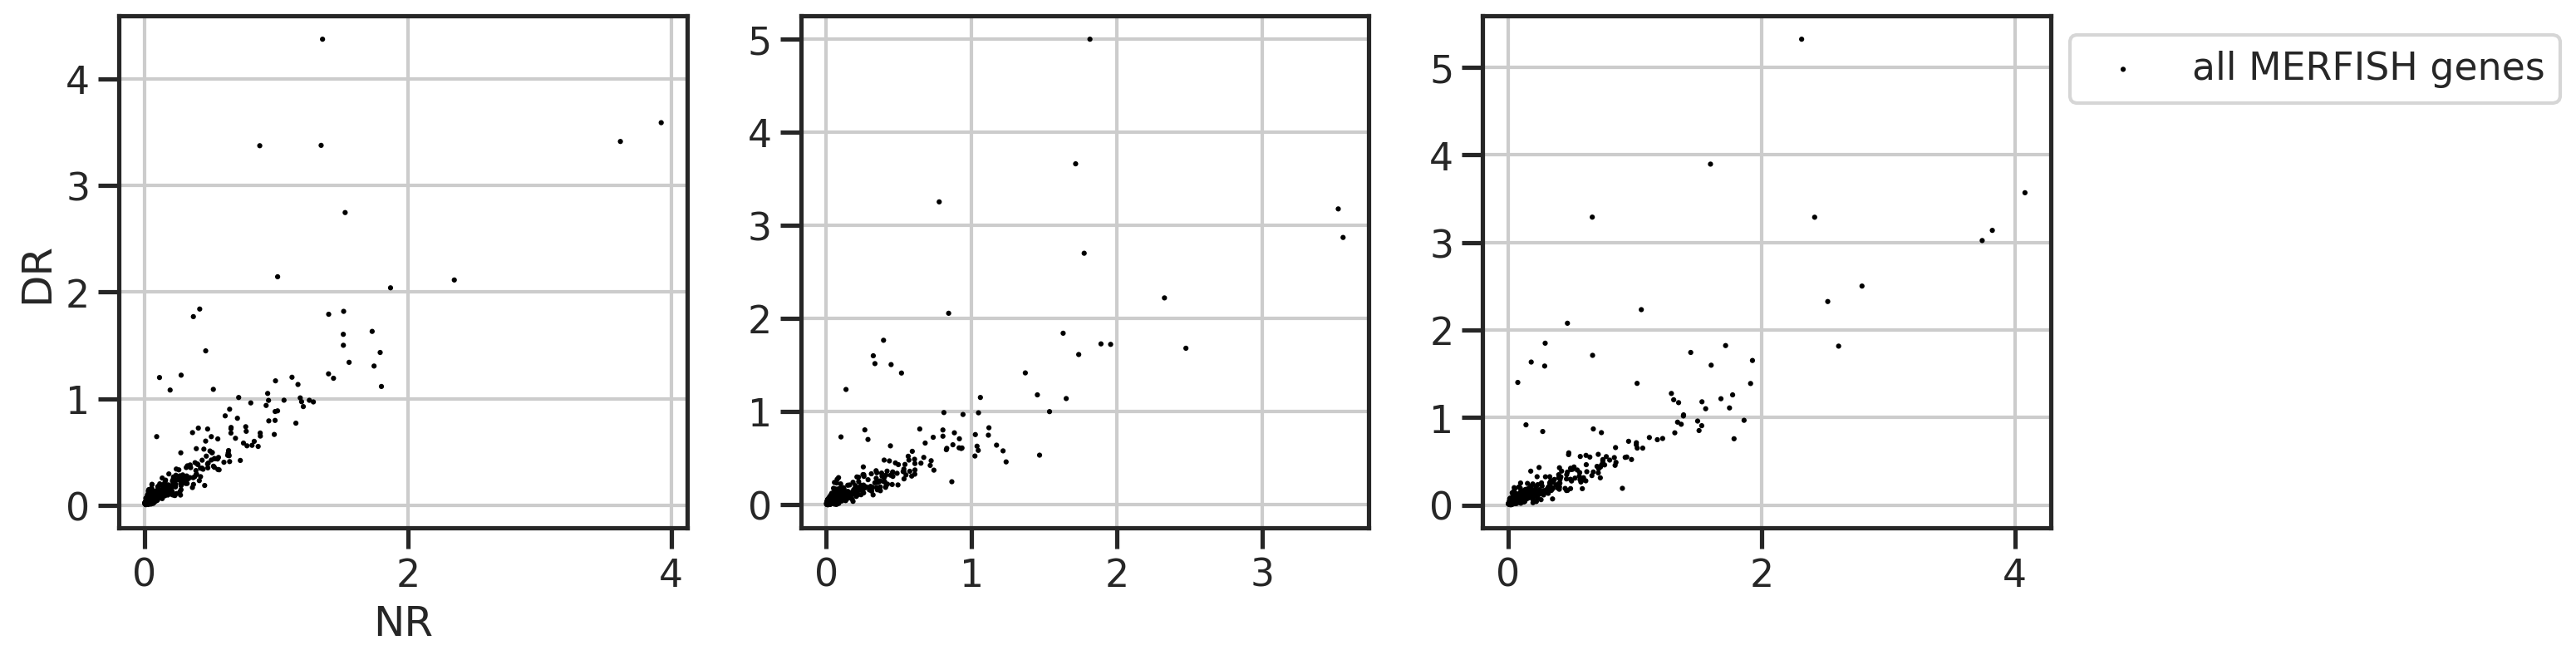

In [46]:
fig, axs = plt.subplots(1,3,figsize=(3*5,1*4))
ax = axs[0]
ax.scatter(dfmean['A_nr'],
           dfmean['A_dr'], 
           s=5, edgecolor='none', color='k', label='all MERFISH genes'
           )
ax.set_xlabel('NR')
ax.set_ylabel('DR')

ax = axs[1]
ax.scatter(dfmean['B_nr'],
           dfmean['B_dr'], 
           s=5, edgecolor='none', color='k', label='all MERFISH genes'
           )
ax = axs[2]
ax.scatter(dfmean['C_nr'],
           dfmean['C_dr'], 
           s=5, edgecolor='none', color='k', label='all MERFISH genes'
           )
ax.legend(bbox_to_anchor=(1,1))
plt